## Progetto Finale di introduzione alla DataScience
con questo notebook ci poniamo l'obiettivo di
* capire quale sia la categoria di applicazioni avente il massimo rapporto tra numero di recensioni e numero di download (che, da adesso, per brevità, chiameremo nr/nd)

* capire, dentro a questa categoria, se sono più le app a pagamento o quelle free ad avere un nr/nd più alto

* investigare l'esistenza di una eventuale correlazione tra il nr/nd e il rating di una applicazione: se questa metrica cresce, generalmente, il rating aumenterà? Diminuirà? Nessuna delle due? Lo scopriremo

Le ipotesi formulate sono quindi le seguenti:
1. immaginiamo che la categoria di applicazioni avente il massimo rapporto tra numero di recensioni e numero di download siano le app di categoria PRODUCTIVITY (e pensiamo che la categoria SOCIAL sia la seconda) 
2. immaginiamo che, all'interno della categoria trovata, generalmente, le app a pagamento avranno un nr/nd più alto rispetto a quelle free
3. immaginiamo che, al crescere del rapporto nr/nd diminuisca il rating (perché pensiamo che, di solito, se la maggior parte degli utilizzatori lascia una recensione, è per criticare qualcosa piuttosto che per esprimere soddisfazione)


trovare la categoria di app che "eccelle" più delle altre in questa metrica potrebbe aiutare, ad esempio, una software house che vuole sviluppare applicazioni particolarmente innovative o che per qualche motivo hanno bisogno di tanti feedback anche dopo varie release: conoscendo i risultati di questa analisi, saprà su quale categoria puntare, avendo trovato la user-base più "attiva" possibile.

In [1]:
## importiamo il necessario:
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import numpy as np
import scipy.stats as stats
import sklearn
#importiamo il dataset e visualizziamo prime 5 righe:
playstore = pd.read_csv('googleplaystore.csv')
playstore.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [2]:
#visualizziamo numero di righe e colonne:
print("Numero Righe, Numero Colonne",playstore.shape)

Numero Righe, Numero Colonne (10841, 13)


In [3]:
#visualizziamo le informazioni del dataset:
playstore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [4]:
#visualizziamo eventuali valori nulli:
playstore.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

Come vediamo ci sono ben 1474 righe che hanno valore nullo sulla colonna Rating, potremmo pensare di
* rimuovere tutte queste righe (e quindi ridurre significativamente la dimensione del nostro dataset)
* "completare" i valori nulli usando il valore medio del rating.
Optiamo per la prima opzione, in quanto la seconda potrebbe portare ad una distorsione dei dati per quanto riguarda l'analisi che ci proponiamo di attuare, infatti, se pensiamo di voler cercare una correlazione tra nr/nd e Rating e usiamo il valore medio in tutte le righe che presentano attualmente un valore nullo, avremo dei risultati irrealistici in tutte queste righe,
## esempio:
il rating medio è 2.3, quindi in 1474 entrate avremo il valore 2.3 sulla colonna Rating, ciò significa che poi, quando andremo a cercare la correlazione, potremmo avere:
App 1: rating = 2.3, nr/nd = 40%
App 2: rating = 2.3, nr/nd = 60%
App 3: rating = 2.3, nr/nd = 99%
e la nostra analisi è stata inquinata, quando magari, rimuovendo le entrate in cui Rating è nullo avremmo trovato una correlazione

In [5]:
#eliminiamo le righe con valori nulli nella colonna 'Rating':
playstore = playstore.dropna(axis=0, subset=['Rating'])
playstore.isnull().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    1
Genres            0
Last Updated      0
Current Ver       4
Android Ver       3
dtype: int64

Analizzando il dataset individuiamo le caratteristiche che, a nostro parere, dovrebbero essere quantitative:
* Rating 
* Reviews
* Installs
* Size
* Price


In [6]:
playstore.describe() #visualizziamo statistiche del dataset

,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


Notiamo che utilizzando il metodo describe abbiamo informazioni solo sulla colonna Rating, come mai le altre (anche se pensiamo essere quantitative) non vengono mostrate?
Perché contengono valori come stringhe.
Inoltre notiamo qualcosa di "curioso" rispetto al valore massimo della colonna Rating, se i rating sul playstore vanno da 1 a 5 stelle, come è possibile che il valore massimo sia 19? C'è una riga problematica nel nostro dataset, che decidiamo di eliminare, in quanto, probabilmente a causa di un errore nel processo di raccolta dei dati, risulta "disallineata", ovvero i valori sono spostati di una colonna:

In [7]:
righe_rumorose = playstore[(playstore['Rating']>5) | (playstore['Rating']<1)]
print("Numero di righe problematiche rispetto al rating: ",righe_rumorose.shape[0]) # controlliamo quante sono, e scopriamo che c'è una sola riga di questo tipo
(righe_rumorose.head(1)) # quindi la visualizziamo con head

Numero di righe problematiche rispetto al rating:  1


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


i valori risultano chiaramente spostati di una colonna (dovrebbe essere Rating = 1.9, Reviews=19, Size = 3.0M, eccetera), ma se volessimo "sistemare" questa colonna ci troveremmo con un valore nullo dentro alla colonna Category, il che non ci fa comodo perché vogliamo fare l'analisi proprio su questa colonna. Quindi decidiamo di eliminare interamente la riga.

In [8]:
(playstore.describe()) # prima di eliminarla, ri-visualizziamo le statistiche del dataset


,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


In [9]:
playstore = playstore.drop(righe_rumorose.index, axis=0) # eliminiamo la riga rumorosa
playstore.describe() # visualizziamo le statistiche del dataset dopo aver eliminato la riga rumorosa

,Rating
count,9366.000000
mean,4.191757
std,0.515219
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,5.000000


**Pulizia dei valori duplicati (se sono presenti)**

In [10]:
#visualizziamo il numero di valori duplicati quindi con lo stesso valore sotto la colonna app:
print("Numero di valori duplicati: ",playstore.duplicated(subset=['App']).sum())
#eliminiamo i valori duplicati:
playstore = playstore.drop_duplicates(subset=['App'])
#verifichiamo che non ci siano più valori duplicati:
print("Numero di valori duplicati: ",playstore.duplicated(subset=['App']).sum())


Numero di valori duplicati:  1170
Numero di valori duplicati:  0


torniamo sulle variabili Install, Reviews, Price e Size, che dovrebbero risultare quantitative ma non accade. Prima di tutto guardiamo il tipo

In [11]:
print("Tipo di Installs:\t" + str(type(playstore['Installs'][0])))
print("Tipo di Reviews:\t" + str(type(playstore['Reviews'][0])))
print("Tipo di Price:\t\t" + str(type(playstore['Price'][0])))
print("Tipo di Size:\t\t" + str(type(playstore['Size'][0])))

Tipo di Installs:	<class 'str'>
Tipo di Reviews:	<class 'str'>
Tipo di Price:		<class 'str'>
Tipo di Size:		<class 'str'>


Notiamo che sono appunto tutte stringhe.
Le uniche colonne che però ci interessa realmente pulire e "rendere quantitative" sono: Installs e Reviews, in quanto Price e Size non giocano alcun ruolo nella nostra analisi.

## Trasformiamo Installs
Installs contiene valore in formato stringa perché il numero di download è espresso nella forma n+, per indicare che è stata scaricata "più di n volte"

In [12]:
if(type(playstore['Installs'][0]) is str):
    playstore['Installs'] = [int(x.replace('+','').replace(',','')) for x in playstore['Installs']]
# ri-controlliamo le statistiche:
playstore.describe()



,Rating,Installs
count,8196.000000,8.196000e+03
mean,4.173243,9.165090e+06
std,0.536625,5.825087e+07
min,1.000000,1.000000e+00
25%,4.000000,1.000000e+04
50%,4.300000,1.000000e+05
75%,4.500000,1.000000e+06
max,5.000000,1.000000e+09


## Trasformiamo Reviews
Reviews contiene valore in formato stringa, lo trasformiamo in numero usando astype(int)

In [13]:
if(type(playstore['Reviews'][0]) is str):
    playstore['Reviews'] = playstore['Reviews'].astype(int)
# ri-controlliamo le statistiche:
playstore.describe()

,Rating,Reviews,Installs
count,8196.000000,8.196000e+03,8.196000e+03
mean,4.173243,2.552515e+05,9.165090e+06
std,0.536625,1.985594e+06,5.825087e+07
min,1.000000,1.000000e+00,1.000000e+00
25%,4.000000,1.260000e+02,1.000000e+04
50%,4.300000,3.004000e+03,1.000000e+05
75%,4.500000,4.381300e+04,1.000000e+06
max,5.000000,7.815831e+07,1.000000e+09


## Drop di colonne che non utilizzeremo
per completare la pulizia, infine, eliminiamo dal dataset le colonne Price e Size (menzionate sopra) e Content Rating, Genres, Last Updated, Current Ver e Android Ver perché di nulla utilità rispetto al nostro obiettivo

In [14]:
playstore.drop(columns=['Price', 'Size', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver'], inplace=True)
playstore.info()


<class 'pandas.core.frame.DataFrame'>
Index: 8196 entries, 0 to 10840
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   App       8196 non-null   object 
 1   Category  8196 non-null   object 
 2   Rating    8196 non-null   float64
 3   Reviews   8196 non-null   int64  
 4   Installs  8196 non-null   int64  
 5   Type      8196 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 706.3+ KB


# Considerazione sul numero di download:
Ha senso, ai fini della nostra analisi, considerare applicazioni con un numero relativamente basso di installazioni?
Immaginiamo lo sviluppatore 'indie' che fa scaricare e recensire la sua app appena sviluppata a tutta la sua famiglia, che possiamo immaginare di 5 componenti, quando andremo a calcolare il nostro rapporto nr/nd avremo 100%, ma è davvero significativo?
Risulta essere un indicatore realmente affidabile su un così basso numero di utenti?
Per questo motivo decidiamo di non considerare le applicazioni con meno di 10000 Installs

In [15]:
# togliamo tutte le applicazioni con meno di 10000 installs:
playstore = playstore[playstore['Installs'] >= 10000]
playstore.describe()

,Rating,Reviews,Installs
count,6435.000000,6.435000e+03,6.435000e+03
mean,4.178104,3.250907e+05,1.167275e+07
std,0.438985,2.235838e+06,6.551800e+07
min,1.600000,6.000000e+00,1.000000e+04
25%,4.000000,9.630000e+02,1.000000e+05
50%,4.300000,1.065800e+04,1.000000e+06
75%,4.500000,7.823500e+04,5.000000e+06
max,5.000000,7.815831e+07,1.000000e+09


In [16]:
# calcoliamo il rapporto tra numero di recensioni e numero di installazioni:
playstore['nr/nd'] = playstore['Reviews'] / playstore['Installs'] * 100
playstore.describe()
# ordiniamo il dataset in base al rapporto tra numero di recensioni e numero di installazioni:
playstore = playstore.sort_values(by='nr/nd', ascending=False)
playstore.head(10) # diamo una occhiata alle prime 10 righe

,App,Category,Rating,Reviews,Installs,Type,nr/nd
4663,Alarmy (Sleep If U Can) - Pro,LIFESTYLE,4.8,10249,10000,Paid,102.490000
7165,My Movies Pro - Movie & TV Collection Library,LIFESTYLE,4.6,6477,10000,Paid,64.770000
9304,Carrier Landings Pro,FAMILY,4.6,5969,10000,Paid,59.690000
9627,ai.type keyboard Plus + Emoji,TOOLS,4.5,57076,100000,Paid,57.076000
4946,Flud (Ad free),VIDEO_PLAYERS,4.8,5639,10000,Paid,56.390000
4556,Day R Premium,FAMILY,4.8,51068,100000,Paid,51.068000
7610,Ski Safari: Adventure Time,FAMILY,4.5,48754,100000,Paid,48.754000
1670,Clash of Clans,GAME,4.6,44891723,100000000,Free,44.891723
4203,The World Ends With You,GAME,4.6,4108,10000,Paid,41.080000
3442,Smart Launcher Pro 3,PERSONALIZATION,4.6,40704,100000,Paid,40.704000


## Problema di precisione nei dati
Notiamo valori sospetti dopo aver calcolato nr/nd ed aver ordinato le righe del dataframe in base a questa metrica (ad esempio un rapporto del 400% dovuto al fatto che ci fossero 4 reviews per una applicazione installata da un solo utente, o 20 per 10 utenti, eccetera... ) questo ci ha portato a ulteriori controlli sui dati.
Siamo ritornati a pulire i dati, in quanto non è possibile che, per una certa applicazione, ci siano più reviews che installazioni.
Ma perché accade questo? Con tutta probabilità, ciò è causato dal fatto che il numero di installazioni non è un numero preciso, bensì un range (infatti come abbiamo detto in precedenza, era indicato nella forma del tipo n+), questo significa che, se una applicazione ha "1+ downloads" essa ha un numero di downloads maggiore o uguale a 1 e però minore di 5, se una applicazione ha un numero di downloads listato come 1,000+ significa che ha tra le 1,000 e  le 5,000 installazioni, e così via.
Mentre, il numero di reviews è un numero preciso.
Per cercare di arginare questo problema procediamo eliminando dal dataset le righe in cui il nr/nd è superiore a 100


In [17]:
# eliminiamo dal dataset le righe in cui nr/nd è maggiore di 100:
playstore = playstore[playstore['nr/nd'] <= 100]

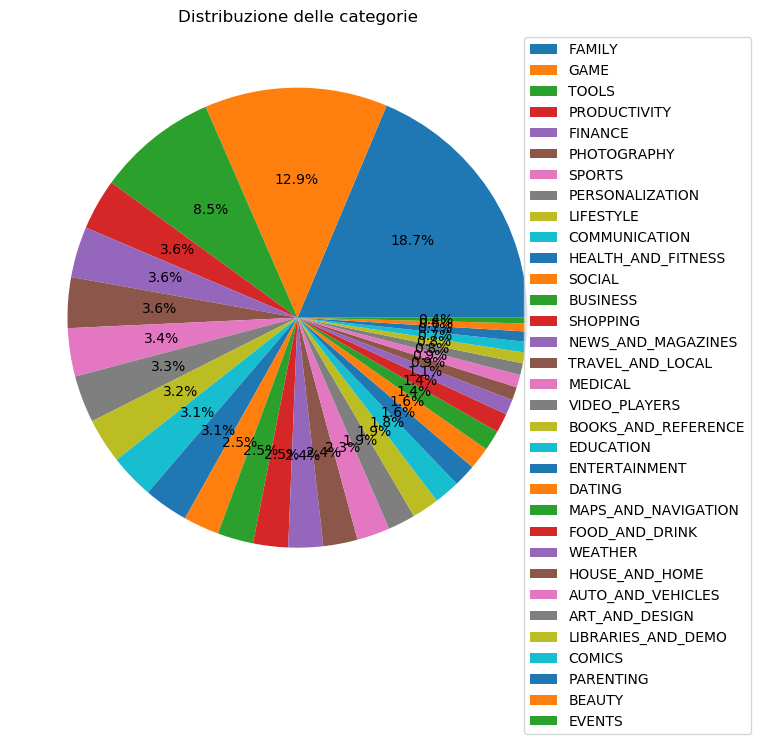

In [18]:
# grafico a torta per vedere la distribuzione delle categorie:
playstore['Category'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(10,10), labels=None)
plt.ylabel('')
plt.title('Distribuzione delle categorie')
plt.subplots_adjust(right=0.7)  # Aggiungi spazio a destra per la legenda
plt.legend(labels=playstore['Category'].value_counts().index, loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()


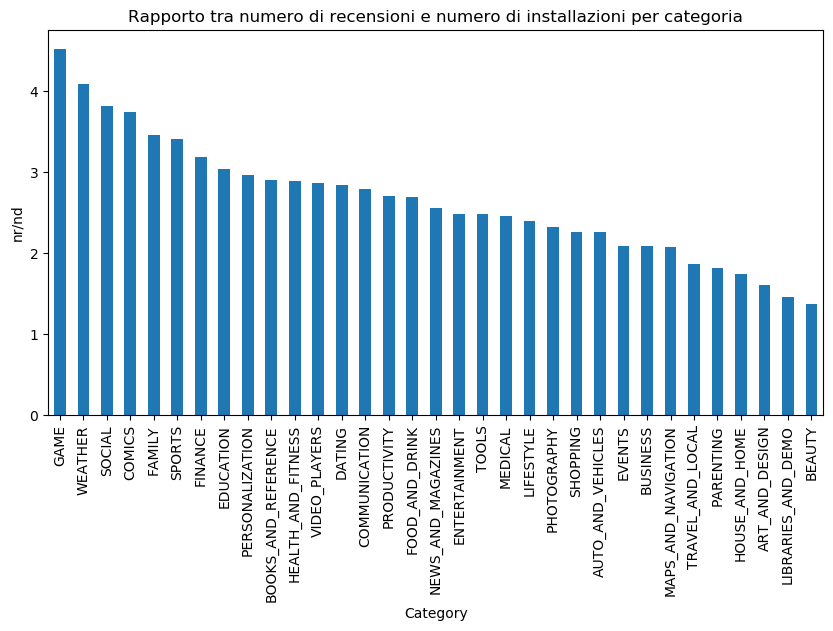

In [19]:


#cerchiamo di capire quale è la categoria con il rapporto tra numero di recensioni e numero di installazioni più alto:
playstore.groupby('Category')['nr/nd'].mean().sort_values(ascending=False).plot.bar(figsize=(10,5)) # ordiniamo le categorie in base al rapporto tra numero di recensioni e numero di installazioni, prendendo ogni categoria e calcolando la media di nr/nd
plt.ylabel('nr/nd')
plt.title('Rapporto tra numero di recensioni e numero di installazioni per categoria')
plt.show()

## Risoluzione obiettivo 1:
Abbiamo quindi scoperto che la categoria di applicazioni con un nr/nd più alto è la categoria GAME, differentemente da quanto ci aspettavamo (avendo inizialmente ipotizzato PRODUCTIVITY)

## Olap

In [20]:
# Recuperiamo le diverse categorie per la rappresentazione OLAP
quantize_category = np.unique(playstore['Category'])
print("Categorie: ", quantize_category)
print("Numero di categorie: ", len(quantize_category))
quantize_rating = ['BAD', 'GOOD']
quatize_nr_nd = ['LOW', 'MEDIUM', 'HIGH']


playstore.info()

'''

OLAP = np.zeros((len(quantize_category), len(quantize_rating), len(quatize_nr_nd)))


playstore.loc[playstore['nr/nd'].between(0, 15), 'nr/nd_quant'] = quatize_nr_nd[0]
playstore.loc[playstore['nr/nd'].between(15, 35), 'nr/nd_quant'] = quatize_nr_nd[1]
playstore.loc[playstore['nr/nd'].between(35, 100), 'nr/nd_quant'] = quatize_nr_nd[2]
for i in range(len(quantize_category)):
    for j in range(len(quantize_rating)):
        for k in range(len(quatize_nr_nd)):
            OLAP[i][j][k] = playstore[(playstore['Category'] == quantize_category[i]) & 
                                       (playstore['Rating_quant'] == quantize_rating[j]) & 
                                       (playstore['nr/nd_quant'] == quatize_nr_nd[k])].shape[0]
print(OLAP)

#Facciamo una heatmap per visualizzare meglio i dati:
fig, ax = plt.subplots()
im = ax.imshow(OLAP[:, :, 0])
ax.set_xticks(np.arange(len(quantize_rating)))
ax.set_yticks(np.arange(len(quantize_category)))
ax.set_xticklabels(quantize_rating)
ax.set_yticklabels(quantize_category)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(quantize_category)):
    for j in range(len(quantize_rating)):
        text = ax.text(j, i, OLAP[i][j][0], ha="center", va="center", color="w")
ax.set_title("Heatmap OLAP")
fig.tight_layout()
plt.show()



'''



Categorie:  ['ART_AND_DESIGN' 'AUTO_AND_VEHICLES' 'BEAUTY' 'BOOKS_AND_REFERENCE'
 'BUSINESS' 'COMICS' 'COMMUNICATION' 'DATING' 'EDUCATION' 'ENTERTAINMENT'
 'EVENTS' 'FAMILY' 'FINANCE' 'FOOD_AND_DRINK' 'GAME' 'HEALTH_AND_FITNESS'
 'HOUSE_AND_HOME' 'LIBRARIES_AND_DEMO' 'LIFESTYLE' 'MAPS_AND_NAVIGATION'
 'MEDICAL' 'NEWS_AND_MAGAZINES' 'PARENTING' 'PERSONALIZATION'
 'PHOTOGRAPHY' 'PRODUCTIVITY' 'SHOPPING' 'SOCIAL' 'SPORTS' 'TOOLS'
 'TRAVEL_AND_LOCAL' 'VIDEO_PLAYERS' 'WEATHER']
Numero di categorie:  33
<class 'pandas.core.frame.DataFrame'>
Index: 6434 entries, 7165 to 3268
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   App       6434 non-null   object 
 1   Category  6434 non-null   object 
 2   Rating    6434 non-null   float64
 3   Reviews   6434 non-null   int64  
 4   Installs  6434 non-null   int64  
 5   Type      6434 non-null   object 
 6   nr/nd     6434 non-null   float64
dtypes: float64(2), int64(2), object(3)
me

'\n\nOLAP = np.zeros((len(quantize_category), len(quantize_rating), len(quatize_nr_nd)))\n\n\nplaystore.loc[playstore[\'nr/nd\'].between(0, 15), \'nr/nd_quant\'] = quatize_nr_nd[0]\nplaystore.loc[playstore[\'nr/nd\'].between(15, 35), \'nr/nd_quant\'] = quatize_nr_nd[1]\nplaystore.loc[playstore[\'nr/nd\'].between(35, 100), \'nr/nd_quant\'] = quatize_nr_nd[2]\nfor i in range(len(quantize_category)):\n    for j in range(len(quantize_rating)):\n        for k in range(len(quatize_nr_nd)):\n            OLAP[i][j][k] = playstore[(playstore[\'Category\'] == quantize_category[i]) & \n                                       (playstore[\'Rating_quant\'] == quantize_rating[j]) & \n                                       (playstore[\'nr/nd_quant\'] == quatize_nr_nd[k])].shape[0]\nprint(OLAP)\n\n#Facciamo una heatmap per visualizzare meglio i dati:\nfig, ax = plt.subplots()\nim = ax.imshow(OLAP[:, :, 0])\nax.set_xticks(np.arange(len(quantize_rating)))\nax.set_yticks(np.arange(len(quantize_category)))\

In [21]:
playstore.loc[playstore['nr/nd'].between(0, 15), 'nr/nd_quant'] = quatize_nr_nd[0]
playstore.loc[playstore['nr/nd'].between(15, 35), 'nr/nd_quant'] = quatize_nr_nd[1]
playstore.loc[playstore['nr/nd'].between(35, 100), 'nr/nd_quant'] = quatize_nr_nd[2]

playstore.loc[playstore['Rating'] <= 3, 'Rating_quant'] = quantize_rating[0]
playstore.loc[playstore['Rating'] > 3, 'Rating_quant'] = quantize_rating[1]


In [22]:
results = pd.DataFrame(columns=['Category', 'Rating', 'nr/nd', 'Count'])
playstore['combined'] = playstore['Category'] + " / " + playstore['Rating_quant'] + " / " + playstore['nr/nd_quant']
playstore.head()


,App,Category,Rating,Reviews,Installs,Type,nr/nd,nr/nd_quant,Rating_quant,combined
7165,My Movies Pro - Movie & TV Collection Library,LIFESTYLE,4.6,6477,10000,Paid,64.770,HIGH,GOOD,LIFESTYLE / GOOD / HIGH
9304,Carrier Landings Pro,FAMILY,4.6,5969,10000,Paid,59.690,HIGH,GOOD,FAMILY / GOOD / HIGH
9627,ai.type keyboard Plus + Emoji,TOOLS,4.5,57076,100000,Paid,57.076,HIGH,GOOD,TOOLS / GOOD / HIGH
4946,Flud (Ad free),VIDEO_PLAYERS,4.8,5639,10000,Paid,56.390,HIGH,GOOD,VIDEO_PLAYERS / GOOD / HIGH
4556,Day R Premium,FAMILY,4.8,51068,100000,Paid,51.068,HIGH,GOOD,FAMILY / GOOD / HIGH


In [23]:
counts = playstore['combined'].value_counts()

for z in range(0,len(quantize_category)):
    for j in range(0,len(quantize_rating)):
        for i in range(0,len(quatize_nr_nd)):
            key = f"{quantize_category[z]} / {quantize_rating[j]} / {quatize_nr_nd[i]}"
            print("Key: ", key) # per vedere come si chiama la chiave (debug)
            count = counts.get(key, 0)
#Aggiungiamo i risultati al dataframe
            results.loc[len(results)] = [quantize_category[z], quantize_rating[j], quatize_nr_nd[i], count]
results.head(1000)


Key:  ART_AND_DESIGN / BAD / LOW
Key:  ART_AND_DESIGN / BAD / MEDIUM
Key:  ART_AND_DESIGN / BAD / HIGH
Key:  ART_AND_DESIGN / GOOD / LOW
Key:  ART_AND_DESIGN / GOOD / MEDIUM
Key:  ART_AND_DESIGN / GOOD / HIGH
Key:  AUTO_AND_VEHICLES / BAD / LOW
Key:  AUTO_AND_VEHICLES / BAD / MEDIUM
Key:  AUTO_AND_VEHICLES / BAD / HIGH
Key:  AUTO_AND_VEHICLES / GOOD / LOW
Key:  AUTO_AND_VEHICLES / GOOD / MEDIUM
Key:  AUTO_AND_VEHICLES / GOOD / HIGH
Key:  BEAUTY / BAD / LOW
Key:  BEAUTY / BAD / MEDIUM
Key:  BEAUTY / BAD / HIGH
Key:  BEAUTY / GOOD / LOW
Key:  BEAUTY / GOOD / MEDIUM
Key:  BEAUTY / GOOD / HIGH
Key:  BOOKS_AND_REFERENCE / BAD / LOW
Key:  BOOKS_AND_REFERENCE / BAD / MEDIUM
Key:  BOOKS_AND_REFERENCE / BAD / HIGH
Key:  BOOKS_AND_REFERENCE / GOOD / LOW
Key:  BOOKS_AND_REFERENCE / GOOD / MEDIUM
Key:  BOOKS_AND_REFERENCE / GOOD / HIGH
Key:  BUSINESS / BAD / LOW
Key:  BUSINESS / BAD / MEDIUM
Key:  BUSINESS / BAD / HIGH
Key:  BUSINESS / GOOD / LOW
Key:  BUSINESS / GOOD / MEDIUM
Key:  BUSINESS / GOO

,Category,Rating,nr/nd,Count
0,ART_AND_DESIGN,BAD,LOW,0
1,ART_AND_DESIGN,BAD,MEDIUM,0
2,ART_AND_DESIGN,BAD,HIGH,0
3,ART_AND_DESIGN,GOOD,LOW,53
4,ART_AND_DESIGN,GOOD,MEDIUM,0
...,...,...,...,...
193,WEATHER,BAD,MEDIUM,0
194,WEATHER,BAD,HIGH,0
195,WEATHER,GOOD,LOW,64
196,WEATHER,GOOD,MEDIUM,5


In [24]:
# printiamo il valore massimo di count
print("Massimo: ", results['Count'].max())
# ordiniamo il dataframe results in base alla colonna count
results = results.sort_values(by='Count', ascending=False)
results.head(10)

Massimo:  1131


,Category,Rating,nr/nd,Count
69,FAMILY,GOOD,LOW,1131
87,GAME,GOOD,LOW,785
177,TOOLS,GOOD,LOW,515
147,PHOTOGRAPHY,GOOD,LOW,221
153,PRODUCTIVITY,GOOD,LOW,221
75,FINANCE,GOOD,LOW,215
171,SPORTS,GOOD,LOW,210
141,PERSONALIZATION,GOOD,LOW,207
39,COMMUNICATION,GOOD,LOW,193
93,HEALTH_AND_FITNESS,GOOD,LOW,187


## Interpretazione della visualizzazione qua sopra
La tabella results di cui abbiamo visualizzato alcune righe ci comunica le seguenti informazioni riguardo al nostro dataset, rispondendo a questa domanda:
Quante sono le applicazioni della categoria X che abbiano un rating buono (o cattivo) ed un nr/nd basso (o medio, o alto)? La risposta a questa domanda viene fornita dalla colonna Count, che conta per l'appunto il numero di occorrenze di tali applicazioni.
*esempio*
ci sono 1131 applicazioni della categoria FAMILY che hanno un rating GOOD ed un nr/nd LOW.

## Prima visualizzazione OLAP proposta
Siccome abbiamo notato che la categoria FAMILY è quella che si "prende la fetta più grande" tra le categorie di applicazioni dello store, e che GAME sia quella mediamente con il rapporto nr/nd più alto, pensiamo sia interessante fare una visualizzazione OLAP per quanto riguarda queste categorie.
**slicing**
Facciamo innanzitutto uno slicing sulla category

In [25]:
print('FAMILY')
family_results = results.loc[results['Category'] == 'FAMILY']
# stampiamo i risultati per la categoria FAMILY
print(family_results)

FAMILY
   Category Rating   nr/nd  Count
69   FAMILY   GOOD     LOW   1131
70   FAMILY   GOOD  MEDIUM     35
66   FAMILY    BAD     LOW     30
71   FAMILY   GOOD    HIGH      5
67   FAMILY    BAD  MEDIUM      0
68   FAMILY    BAD    HIGH      0


**visualizziamo adesso questa matrice, con una heatmap**

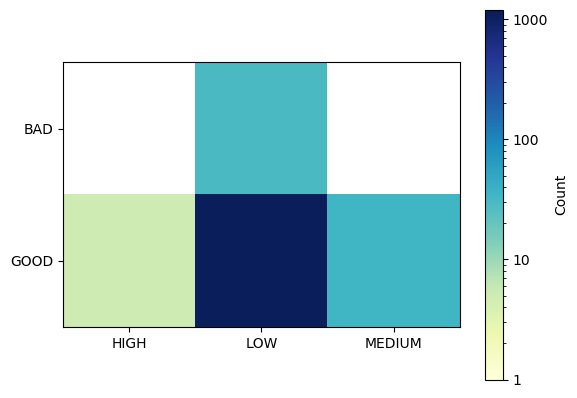

In [26]:
# Trasformiamo i dati in una matrice utilizzando il metodo pivot
matrix = family_results.pivot(index='Rating', columns='nr/nd', values='Count')
# Creiamo la heatmap utilizzando imshow
plt.imshow(matrix, cmap='YlGnBu', interpolation='nearest', norm=mcolors.LogNorm(vmin=1, vmax=1200))

# Aggiungiamo una colorbar per indicare il valore dei colori
cbar = plt.colorbar(label='Count')

# Impostiamo le etichette degli assi
plt.xticks(np.arange(len(matrix.columns)), matrix.columns)
plt.yticks(np.arange(len(matrix.index)), matrix.index)

# Modifichiamo le etichette della colorbar, ci sembra più chiaro avere 1, 10, 100, 1000 espressi così, piuttosto che come potenze di 10 (di default)
ticks = [1, 10, 100, 1000]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)
# Mostriamo il grafico
plt.show()

Con questo slicing notiamo che la maggior parte delle app per famiglie hanno un nr/nd basso e che la maggior parte di esse hanno un rating buono

**slicicng rispetto a category visualizzando i giochi**

In [27]:
print('GAME')
game_results = results.loc[results['Category'] == 'GAME']
# stampiamo i risultati per la categoria GAME
print(game_results)

GAME
   Category Rating   nr/nd  Count
87     GAME   GOOD     LOW    785
88     GAME   GOOD  MEDIUM     33
89     GAME   GOOD    HIGH      5
84     GAME    BAD     LOW      5
85     GAME    BAD  MEDIUM      0
86     GAME    BAD    HIGH      0


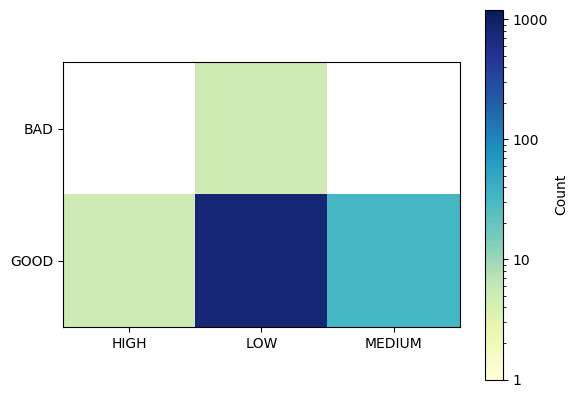

In [28]:
# Trasformiamo i dati in una matrice utilizzando il metodo pivot
matrix = game_results.pivot(index='Rating', columns='nr/nd', values='Count')
# Creiamo la heatmap utilizzando imshow
plt.imshow(matrix, cmap='YlGnBu', interpolation='nearest', norm=mcolors.LogNorm(vmin=1, vmax=1200))

# Aggiungiamo una colorbar per indicare il valore dei colori
cbar = plt.colorbar(label='Count')

# Impostiamo le etichette degli assi
plt.xticks(np.arange(len(matrix.columns)), matrix.columns)
plt.yticks(np.arange(len(matrix.index)), matrix.index)

# Modifichiamo le etichette della colorbar, ci sembra più chiaro avere 1, 10, 100, 1000 espressi così, piuttosto che come potenze di 10 (di default)
ticks = [1, 10, 100, 1000]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)
# Mostriamo il grafico
plt.show()

Forse stiamo iniziando a notare un trend? Sia in questa slicing su GAME, che in quello su FAMILY, c'è una totale assenza di occorrenze delle combinazioni: (nr/nd medio, rating cattivo) ed (nr/nd alto, rating cattivo)

## Test Statistico
Dopo aver condotto l'analisi, abbiamo identificato la categoria "game" come quella con il valore più elevato di nr/nd.
Presumiamo che la maggior parte delle applicazioni in questa categoria siano a pagamento. Questa supposizione si basa sul ragionamento che gli utenti che pagano per un'applicazione sono probabilmente più inclini a lasciare recensioni dettagliate, sia positive che negative. Questo perché l'atto di acquisto potrebbe indicare un maggiore coinvolgimento o aspettative più elevate da parte dell'utente rispetto alle app gratuite.

## Metodo predittivo
utilizziamo una rappresentazione grafica per verificare se le due features (nr/nd e rating) siano correlate, e se sia quindi possibile utilizzare una di queste features per predire l'altra.

Text(0, 0.5, 'Rating')

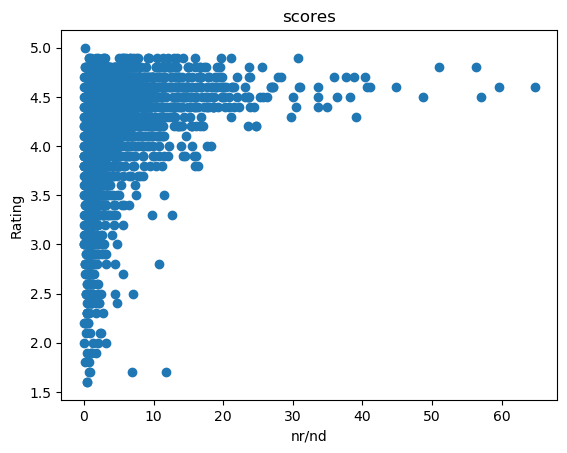

In [39]:
plt.scatter(playstore['nr/nd'], playstore['Rating'])
plt.title('scores')
plt.xlabel('nr/nd')
plt.ylabel('Rating')

verifichiamo la correlazione utilizzando il coefficiente di correlazione di Pearson (r).

In [41]:
correlation, p_value = stats.pearsonr(playstore['nr/nd'],playstore['Rating'])
print("Coefficiente di Pearson: ", correlation)


Coefficiente di Pearson:  0.2723173747155313


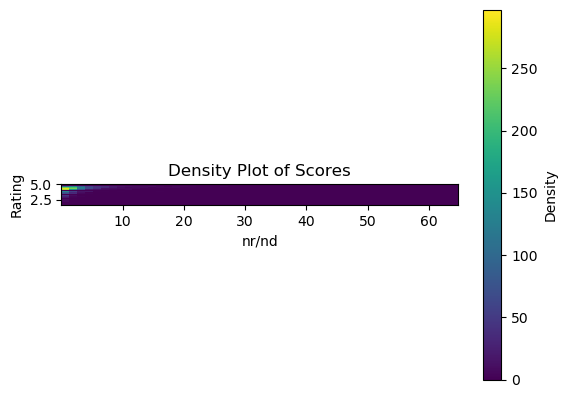

In [42]:
# Calcoliamo una rappresentazione a griglia della densità dei punti
x = playstore['nr/nd']
y = playstore['Rating']
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# Plottiamo il grafico a dispersione in falsi colori
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis')
plt.colorbar(label='Density')
plt.title('Density Plot of Scores')
plt.xlabel('nr/nd')
plt.ylabel('Rating')
plt.show()

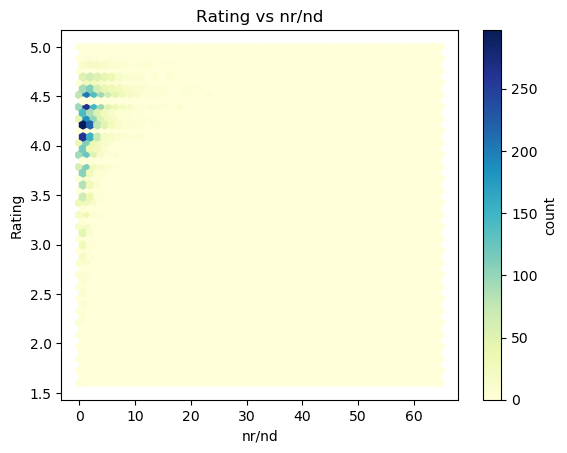

In [35]:
#Plottiamo in falsi color con un hexbin plot:
plt.hexbin(playstore['nr/nd'], playstore['Rating'], gridsize=50, cmap='YlGnBu')
plt.xlabel('nr/nd')
plt.ylabel('Rating')
plt.title('Rating vs nr/nd')
plt.colorbar(label='count')
plt.show()

In [43]:
from sklearn.model_selection import train_test_split
#codice qui 
# Definiamo le caratteristiche da usare
X = playstore[['nr/nd']] #nr/nd sarà il nostro predittore
y = playstore['Rating'] #Rating sarà la variabile da predire (target)

# Dividiamo il dataset in training set e validation set usando la proporzione 70/30
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [44]:
from sklearn.linear_model import LinearRegression
# Istanziamo l'oggetto della classe LinearRegression
regressor = LinearRegression()

# Alleniamo il modello passando il training set
regressor.fit(X_train, y_train)

# Visualizziamo i coefficienti imparati
print("Intercept:", regressor.intercept_)
#usiamo l'indexing e prendiamo il primo (e unico) coefficiente, ma se avessimo più variabili predittive (altre oltre imdb_score)
#potremmo accedere ai coefficienti relativi a tutte in questo array
print("Coefficiente nr/nd", regressor.coef_[0]) 


Intercept: 4.092397682955053
Coefficiente nr/nd 0.02825438802545882


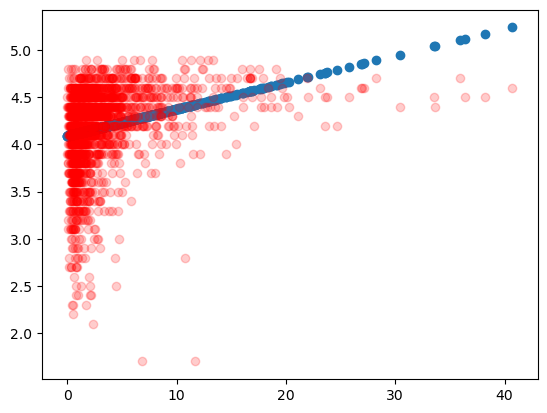

In [45]:
y_hat =regressor.predict(X_valid)

plt.scatter(X_valid,y_hat)
plt.scatter(X_valid,y_valid,c='r',alpha=0.2)

## Usiamo le tre stime per capire quanto precisa è la funzione imparata


In [46]:
import sklearn.metrics as metrics 
y_pred = regressor.predict(X_valid)
print ('MAE:', metrics.mean_absolute_error(y_valid, y_pred))
print ('MSE:', metrics.mean_squared_error(y_valid, y_pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, y_pred)))

MAE: 0.31013517872291907
MSE: 0.17648797763986968
RMSE: 0.4201047222299098


## Determiniamo il modello nullo e confrontiamo le metriche appena ottenute

In [47]:
def MSE (y_pred,y_true):
    #errore quadratico medio
    mse = np.mean((y_pred - y_true) ** 2)
    return mse 

def MAE (y_pred,y_true):
    #scarto medio assoluto
    mae = np.mean(np.abs(y_pred - y_true))
    return mae


def RMSE (y_pred,y_true):
    #radice quadrata dell'errore quadratico medio
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    return rmse


# calcoliamo il nr/nd medio
mean_nr_nd = playstore['nr/nd'].mean()
# creiamo la nuova x con lo stesso numero di campioni del validation set originale, e con tutti i valori uguali a mean_nr_nd appena calcolato
null_model = [mean_nr_nd] * y_valid.shape[0]

null_mae = MAE(null_model, y_valid)
null_mse = MSE(null_model, y_valid)
null_rmse = RMSE(null_model, y_valid)

#stampate gli errori
print("Scarto medio assoluto (MAE):", null_mae)
print("Errore quadratico medio (MSE):", null_mse)
print("Radice dell'errore quadratico medio (RMSE):", null_rmse)

Scarto medio assoluto (MAE): 1.150975063320676
Errore quadratico medio (MSE): 1.4723934776169305
Radice dell'errore quadratico medio (RMSE): 1.2134222173740394


## Clustering

/home/iosifip/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


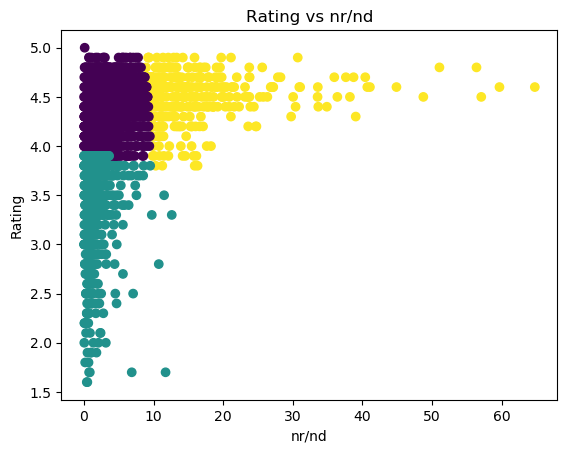

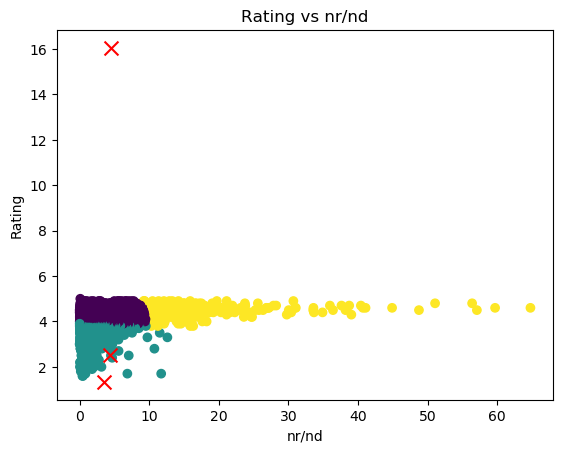

,App,Category,Rating,Reviews,Installs,Type,nr/nd,nr/nd_quant,Rating_quant,combined,Cluster
7165,My Movies Pro - Movie & TV Collection Library,LIFESTYLE,4.6,6477,10000,Paid,64.770,HIGH,GOOD,LIFESTYLE / GOOD / HIGH,2
9304,Carrier Landings Pro,FAMILY,4.6,5969,10000,Paid,59.690,HIGH,GOOD,FAMILY / GOOD / HIGH,2
9627,ai.type keyboard Plus + Emoji,TOOLS,4.5,57076,100000,Paid,57.076,HIGH,GOOD,TOOLS / GOOD / HIGH,2
4946,Flud (Ad free),VIDEO_PLAYERS,4.8,5639,10000,Paid,56.390,HIGH,GOOD,VIDEO_PLAYERS / GOOD / HIGH,2
4556,Day R Premium,FAMILY,4.8,51068,100000,Paid,51.068,HIGH,GOOD,FAMILY / GOOD / HIGH,2


In [48]:
#Facciamo un esempio di clustering con i dati a disposizione:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#Selezioniamo solo le colonne che ci interessano:
X = playstore[['Rating', 'nr/nd']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Addestriamo il modello di clustering:
model = KMeans(n_clusters=3)
model.fit(X_scaled)

#Aggiungiamo le predizioni al dataset:
playstore['Cluster'] = model.predict(X_scaled)

#Visualizziamo i cluster:
plt.scatter(playstore['nr/nd'], playstore['Rating'], c=playstore['Cluster'], cmap='viridis')
plt.xlabel('nr/nd')
plt.ylabel('Rating')
plt.title('Rating vs nr/nd')
plt.show()

#Visualizziamo i centroidi dei cluster:
centroids = scaler.inverse_transform(model.cluster_centers_)
plt.scatter(playstore['nr/nd'], playstore['Rating'], c=playstore['Cluster'], cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red', s=100)
plt.xlabel('nr/nd')
plt.ylabel('Rating')
plt.title('Rating vs nr/nd')
plt.show()

#Visualizziamo il numero di app per cluster:
playstore['Cluster'].value_counts()

#Visualizziamo le statistiche per ogni cluster:
playstore.groupby('Cluster').describe()

#Visualizziamo le app di ogni cluster:
playstore[playstore['Cluster'] == 0].head()

playstore[playstore['Cluster'] == 1].head()

playstore[playstore['Cluster'] == 2].head()